In [1]:
import tensorflow as tf
from tensorflow.keras import datasets


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [2]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [3]:
conv_arch = ((1, 128), (1, 256), (2, 256), (2, 512), (2, 512))

In [4]:
len(train_images[0][0])

32

In [5]:
# Задаем сеть VGG
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # Сверточная часть
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

In [6]:
input_shape=(None,32, 32, 3)
net.build(input_shape)
net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 16, 16, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 4, 4, 256)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 2, 2, 512)           │       3,539,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 1, 1, 512)           │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 10)                  │      13,280,394 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,018,890 (87.81 MB)

 Trainable params: 23,018,890 (87.81 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import math

def cosine_annealing_lr(epoch, lr, num_epochs):
    return initial_lr * (1 + math.cos(math.pi * epoch / num_epochs)) / 1.8


In [11]:
num_epochs = 22

In [12]:
initial_lr = 4e-4
optimizer = tf.keras.optimizers.AdamW(learning_rate = initial_lr)
net.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: cosine_annealing_lr(epoch, initial_lr, num_epochs))


In [13]:
%%time
history = net.fit(train_images, train_labels, epochs=num_epochs,
                    validation_data=(test_images, test_labels),
                    batch_size = 128,  callbacks=[lr_callback])

Epoch 1/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.1583 - loss: 2.4546 - val_accuracy: 0.3396 - val_loss: 1.6600 - learning_rate: 4.4444e-04
Epoch 2/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.3736 - loss: 1.6208 - val_accuracy: 0.4964 - val_loss: 1.3127 - learning_rate: 4.4218e-04
Epoch 3/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5167 - loss: 1.2833 - val_accuracy: 0.6042 - val_loss: 1.1778 - learning_rate: 4.3544e-04
Epoch 4/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.6399 - loss: 1.0480 - val_accuracy: 0.6790 - val_loss: 0.9440 - learning_rate: 4.2436e-04
Epoch 5/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.7068 - loss: 0.8749 - val_accuracy: 0.7180 - val_loss: 0.8548 - learning_rate: 4.0917e-04
Epoch 6/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.7544 - loss: 0.7418 - val_accuracy: 0.7317 - val_loss: 0.8206 - learning_rate: 3.9017e-04
Epoch 7/22
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


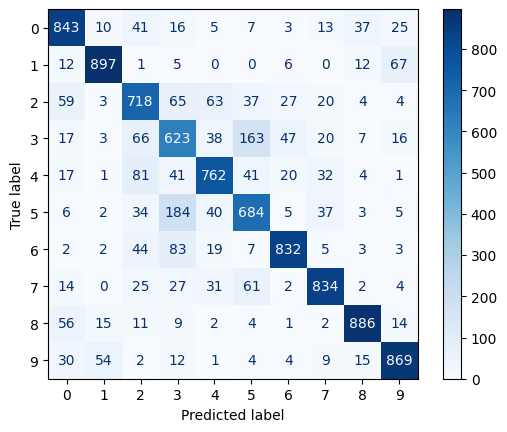

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = net.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(test_labels, predicted_labels)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot(cmap=plt.cm.Blues)
plt.show()

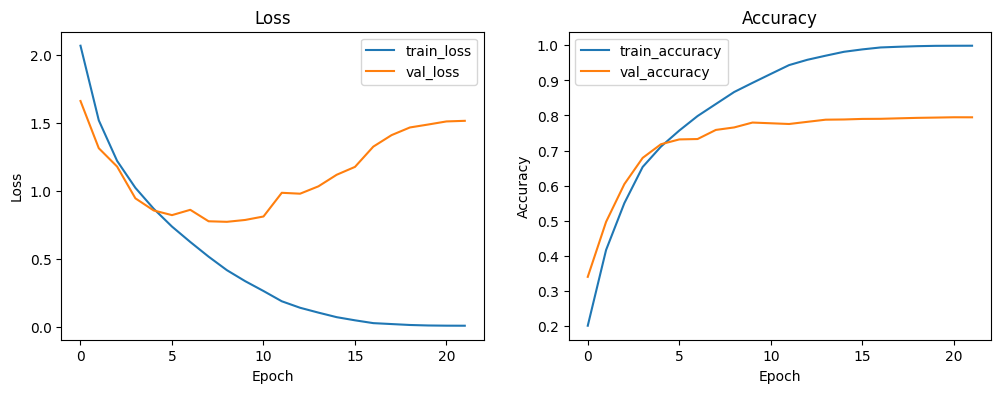

In [17]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # График ошибки
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Вызов функции для визуализации
plot_history(history)